# U-Net: Training Image Segmentation Models in Tensorflow

Copyright 2016 The BigDL Authors.

SparkXshards in Orca allows users to process large-scale dataset using existing Python codes in a distributed and data-parallel fashion, as shown below. This notebook is an example of training U-Net, an image segmentation model in tensforflow on Orca Estimtor and SparkXShard of images. 

It is adapted from [Cats vs Dogs:- Basic tensorflow CNN tutorial](https://www.kaggle.com/code/ruchibahl18/cats-vs-dogs-basic-cnn-tutorial) on [Kaggle Dogs vs. Cats data](https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data). 

In [ ]:
# import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

from bigdl.orca.data.shard import SparkXShards
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.learn.tf2.estimator import Estimator
import bigdl.orca.data

import numpy as np
from IPython.display import display

Start an OrcaContext and give a bit more memory.

In [ ]:
sc = init_orca_context(cluster_mode="local", cores=4, memory="8g")

##  Load images into SparkXShards in parallel

Load data into data_shards, it is a SparkXshards that can be operated on in parallel. Here each record is a tuple of (image: PIL.Image.Image and label), label is retrieved from get_label function of filename.

In [3]:
input_dir = '../dogs-vs-cats/'

def get_label(file_name):
    label = [1] if 'dog' in file_name.split('/')[-1] else [0]
    return label

data_shards = bigdl.orca.data.read_images(input_dir, get_label)

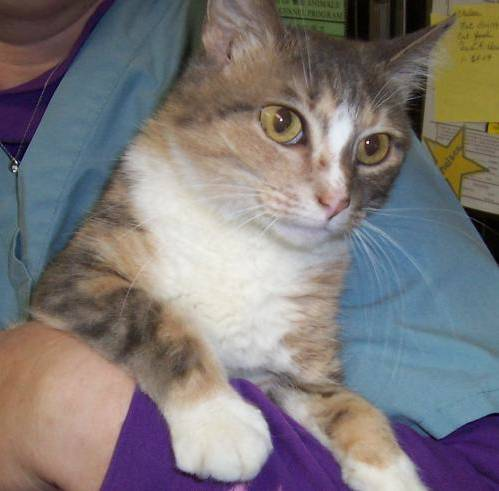

In [4]:
# take a look at the data
image, label = data_shards.first()
display(image)

In [5]:
# see the num of partitions of data_shards
data_shards.num_partitions()

4

## Transformation of the images

Define a train_transform function directly using methods of torchvision transforms 

In [6]:
img_size = (80, 80)
def train_transform(im):
    features = im[0]
    width, height = features.size  # Get dimensions
    left = width / 4
    top = height / 4
    right = 3 * width / 4
    bottom = 3 * height / 4
    features = features.crop((left, top, right, bottom))
    features = features.resize(img_size)
    return np.asarray(features), im[1]

In [7]:
data_shards = data_shards.transform_shard(train_transform)

Stack elements of each partition into an ndarray of features and labels for efficient training

In [8]:
data_shards = data_shards.stack_feature_labels()

## The model

Build the U-Net model model using tensorflow keras APIs. Here, model is copied from [Keras implementation](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [9]:

def get_model():
    model = Sequential()
    # Adds a densely-connected layer with 64 units to the model:
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(80, 80, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Add another:
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

define a model_creator for Orca Estimator and show the summary of model structure

In [10]:
# Build model and compile with optimizer and loss function
def model_creator(config):
    model = get_model()
    print(model.summary())
    model.compile(optimizer="adam",
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
est = Estimator.from_keras(model_creator=model_creator)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 8
steps_per_epoch = len(data_shards) // BATCH_SIZE

est.fit(data=data_shards,
        batch_size=BATCH_SIZE,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS)

In [ ]:
stop_orca_context()